# CropGuard: Building an AI-powered Crop Disease Detector

---

## Project Overview

CropGuard is a lightweight, web-deployable AI application to **detect crop diseases from leaf images**.  
Our target crops are:

- **Tomato**
- **Potato**
- **Grape**

The end goal is to **classify an input leaf image** into one of two categories:
- **Healthy**
- **Sick**

If a leaf is classified as sick, we will also predict the **specific disease type** and show relevant **treatment tips**.

---

## Dataset

We are using the **PlantVillage** dataset, a widely used open dataset for plant disease detection.  
It contains thousands of labeled images across various crop types and diseases.

---

## Project Approach

This project will follow a clear, modular pipeline:

1. **Data Handling and Preprocessing**  
   (Dataset organization, cleaning, train/val/test splits)

2. **Data Augmentation and Pipeline Building**  
   (Transformations, Datasets, DataLoaders)

3. **Model Training with Transfer Learning**  
   (MobileNetV2)

4. **App Development and Deployment**  
   (Gradio/Streamlit frontend + Docker + CI/CD)
   
5. **Visualization and Explainability**  
   (GradCAM visualizations)

In this first notebook, we will:

- Check the integrity of the raw dataset
- Organize images into **train/val/test** splits
- Prepare the dataset directory structure needed for model training
- Set up basic data augmentation transforms

---

In [2]:
import sys
import os

current_dir = os.getcwd()
print(f"[DEBUG] Current working directory: {current_dir}")

project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"[DEBUG] Project root added to sys.path: {project_root}")

from src.data.download import download_and_extract_dataset, clean_and_organize_dataset, check_data_integrity

# Where it should be
print("Checking if /CropGuard/data/clean exists:", os.path.exists("../data/clean"))

# What's actually inside data/
print("Contents of /data/:", os.listdir("../data"))

[DEBUG] Current working directory: /Users/mitra/vibe_code/CropGuard/notebooks
[DEBUG] Project root added to sys.path: /Users/mitra/vibe_code/CropGuard
Checking if /CropGuard/data/clean exists: True
Contents of /data/: ['clean']


# Step 1: Download PlantVillage dataset

We shall download the subset of the PlantVillage dataset for the following crops:

1) tomato
2) potato
3) grapes

In [4]:
# Step 1: Download and unzip dataset into data/plant_disease_raw/
download_and_extract_dataset()

# Step 2: Clean and move only potato, tomato, grape into data/clean/
clean_and_organize_dataset()

# Step 3: Check if everything is organized correctly
check_data_integrity()

[INFO] Downloading PlantVillage dataset...
Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
[INFO] Download complete and extracted.
[INFO] Crops cleaned and organized into 'clean/' directory from train and val folders.
[INFO] Deleted raw data directory at /Users/mitra/vibe_code/CropGuard/data/plant_disease_raw after cleaning.
[INFO] Potato: 3 disease classes found.
[INFO] Grape: 4 disease classes found.
[INFO] Tomato: 10 disease classes found.


# Step 2: Organize Data into Train/Validation/Test Splits

We split the images into:

- **70% Training**
- **15% Validation**
- **15% Testing**

For each crop class, images are shuffled and assigned to these splits.  
This ensures a clean and reproducible training setup.

In [6]:
# Create train/val/test splits
from src.data.preprocess import split_clean_data

split_clean_data()

[INFO] Finished creating train/val/test split.


# Step 3: Verify Split Directory Structure

Let's check if the train/val/test directories were created properly and populated with images.

In [11]:
from src.utils.config import SPLIT_DIR

def verify_split_structure():
    """
    Verify that split/train, split/val, split/test directories exist and are populated correctly.
    """
    expected_splits = ["train", "val", "test"]

    for split_name in expected_splits:
        split_path = os.path.join(SPLIT_DIR, split_name)
        if not os.path.exists(split_path):
            print(f"[ERROR] {split_name} directory missing at {split_path}")
            continue
        
        print(f"[INFO] {split_name.upper()} directory found.")

        total_images = 0
        for crop in os.listdir(split_path):
            crop_path = os.path.join(split_path, crop)
            for disease_folder in os.listdir(crop_path):
                disease_path = os.path.join(crop_path, disease_folder)
                n_images = len(os.listdir(disease_path))
                total_images += n_images
                print(f"   - {crop}/{disease_folder}: {n_images} images")

        print(f"[SUMMARY] Total images in {split_name}: {total_images}\n")

verify_split_structure()

[INFO] TRAIN directory found.
   - potato/Potato___Early_blight: 700 images
   - potato/Potato___Late_blight: 700 images
   - potato/Potato___healthy: 106 images
   - grape/Grape___Black_rot: 826 images
   - grape/Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 753 images
   - grape/Grape___healthy: 296 images
   - grape/Grape___Esca_(Black_Measles): 968 images
   - tomato/Tomato___Target_Spot: 982 images
   - tomato/Tomato___Late_blight: 1336 images
   - tomato/Tomato___Tomato_mosaic_virus: 261 images
   - tomato/Tomato___Leaf_Mold: 666 images
   - tomato/Tomato___Bacterial_spot: 1488 images
   - tomato/Tomato___Early_blight: 700 images
   - tomato/Tomato___healthy: 1113 images
   - tomato/Tomato___Tomato_Yellow_Leaf_Curl_Virus: 3749 images
   - tomato/Tomato___Spider_mites Two-spotted_spider_mite: 1173 images
   - tomato/Tomato___Septoria_leaf_spot: 1239 images
[SUMMARY] Total images in train: 17056

[INFO] VAL directory found.
   - potato/Potato___Early_blight: 150 images
   - potato/Po

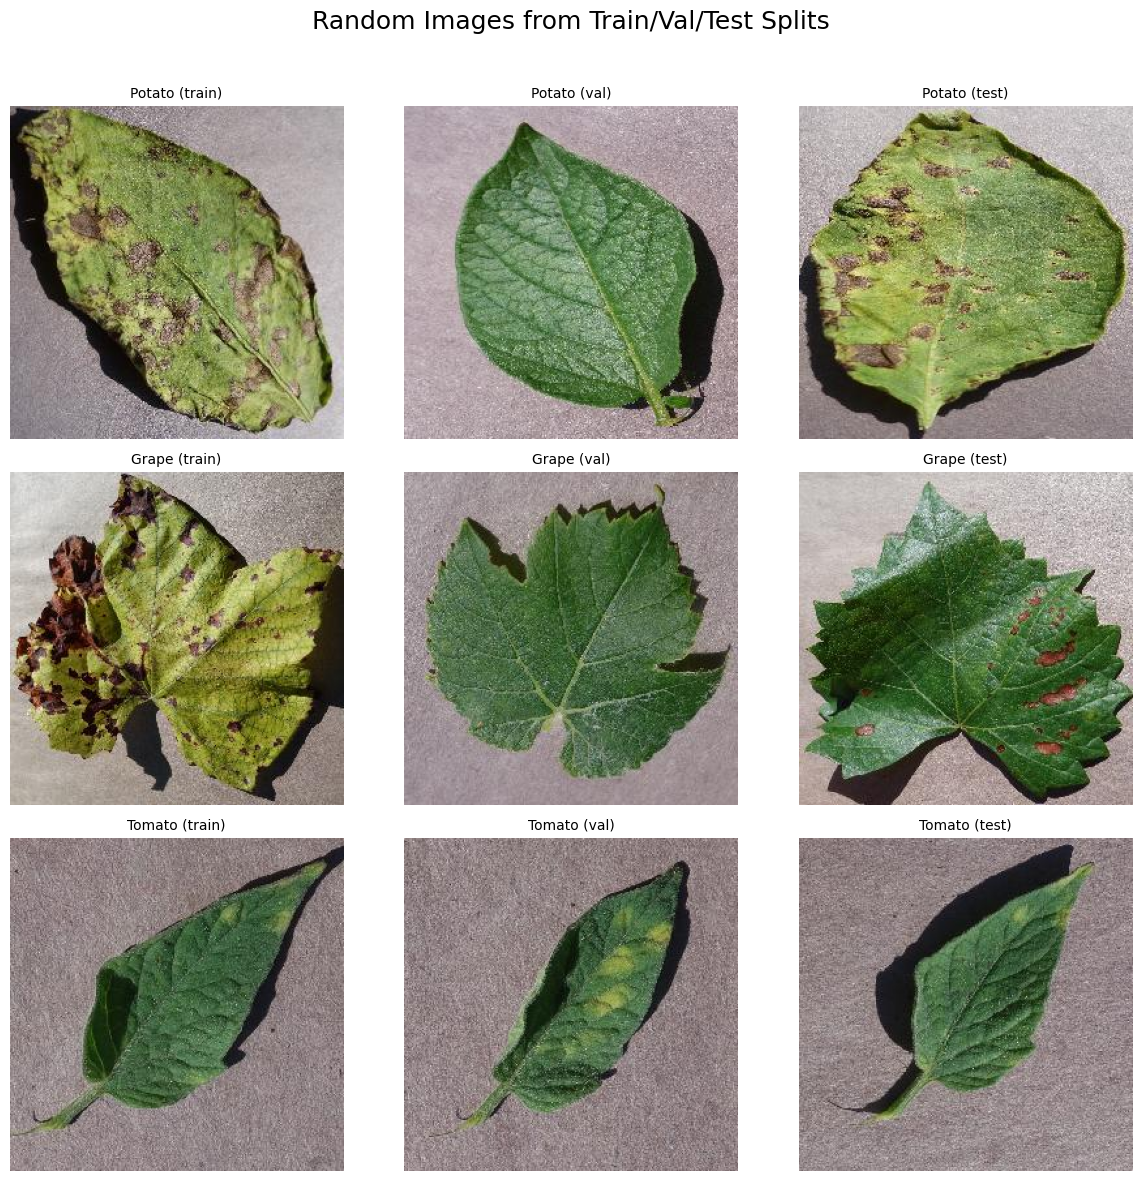

In [41]:
import random
import os
from PIL import Image
from src.utils.config import SPLIT_DIR, TARGET_CROPS
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from src.utils.config import SPLIT_DIR

def plot_random_examples():
    """
    Plot 3x3 grid: 1 random image per crop (potato, grape, tomato) across train/val/test.
    """
    splits = ["train", "val", "test"]
    crops = ["potato", "grape", "tomato"]  # ✅ Explicit here

    fig, axes = plt.subplots(len(crops), len(splits), figsize=(12, 12))
    fig.suptitle("Random Images from Train/Val/Test Splits", fontsize=18)

    for i, crop in enumerate(crops):
        for j, split in enumerate(splits):
            crop_dir = os.path.join(SPLIT_DIR, split, crop)

            if not os.path.exists(crop_dir) or len(os.listdir(crop_dir)) == 0:
                axes[i, j].axis('off')
                continue

            disease_classes = [d for d in os.listdir(crop_dir) if os.path.isdir(os.path.join(crop_dir, d))]
            if not disease_classes:
                axes[i, j].axis('off')
                continue

            selected_disease = random.choice(disease_classes)
            disease_path = os.path.join(crop_dir, selected_disease)

            images = [img for img in os.listdir(disease_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if not images:
                axes[i, j].axis('off')
                continue

            selected_img = random.choice(images)
            img_path = os.path.join(disease_path, selected_img)

            try:
                img = Image.open(img_path).convert("RGB")
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{crop.capitalize()} ({split})", fontsize=10)
                axes[i, j].axis('off')
            except Exception as e:
                print(f"[WARNING] Could not load image: {img_path}. Error: {e}")
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_random_examples(